<a href="https://colab.research.google.com/github/IrisLiu07311370/DS/blob/main/project_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Project Title]

**Course:**  Foundations of Data Science

**Group Members:** [Member Name 1], [Member Name 2], [Member Name 3]

## 1. Introduction


### 1.1. The Question / Estimand

*(Provide a clear statement of the question you are investigating.)*

### 1.2. Data Description

*(Describe the dataset you are using. )*
* *Where did the data come from? (Provide a link or upload it).*
* *What do the rows and columns represent?*
* *Why is this dataset appropriate for your causal question?*

## 2. Causal Model

*(Describe your causal model. This section must include a **connected** Directed Acyclic Graph (DAG). Insert an image of your DAG here or create it with code.)*

### 2.1. Variables

*(Clearly label and describe your three variables (Treatment, Outcome, Confound). Do not use T,Y,Z. Use symbols that reflect the names of the variables from your dataset.)*

* **T (Treatment):** [Variable Name] - [Description]
* **Y (Outcome):** [Variable Name] - [Description]
* **Z (Confound):** [Variable Name] - [Description]

### 2.2. Assumed Causal Relationships

*(Clearly describe the assumed causal relationships between the variables as represented in your DAG. )*

## 3. Statistical Model

*(Describe the full statistical model you are using, preferably with statistical notation. DO NOT USE THIS EXACT MODEL DEFINITION IF IT IS NOT APPROPRIATE FOR YOUR PROJECT.)*

*(Example:)*  

$$ Y_i \sim \text{Normal}(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta_T T_i + \beta_Z Z_i $$
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \beta_T \sim \text{Normal}(0, 1) $$
$$ \beta_Z \sim \text{Normal}(0, 1) $$
$$ \sigma \sim \text{Exponential}(1) $$

### 3.1. Justification of Priors

*(Justify the priors used in your model. This can be based on prior predictive simulation, information from outside the dataset, or both. )*

### 3.2. Justification of Outcome Distribution

*(Explain why your chosen distribution for the outcome variable (e.g., Normal, Bernoulli, Poisson) is reasonable given the observed data. )*

### 3.3. Handling the Confound

*(Explain how your statistical model properly handles the confounding variable to provide a valid causal estimate. )*

## 4. Model Validation on Simulated Data

*(Before analyzing the real data, you must validate your statistical model on simulated data where you pre-define the parameter values, construct a posterior approximation of your model using the simulated data, and evaluate how well your model estimates the pre-defined parameter values.)*

*(**Hint:** Use `arviz.plot_posterior()` with the `ref_val` parameter set to your fixed simulation parameter values to check how well your model estimates them. )*

In [ ]:
# 1. Define fixed parameter values (e.g., alpha_sim = 0.3, beta_sim = 0.5, etc)

# 2. Simulate data based on your causal/statistical model using these fixed values

# 3. Run your computational model (using PyMC) on this simulated data

# 4. Check how well your model estimates the parameter values. Do the posterior estimates from the model capture the true values you defined?


In [1]:
import pandas as pd
import pymc as pm
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
# Simulated true model parameters
a_sim = 5.1
b_sim = 0.25
sigma_sim = 0.4

# Simulated log-transformed and normalized citation counts
N = 500
C_sim = stats.uniform.rvs(-2, 2, N)

# Simulated observed ratings
mu_sim = a_sim + b_sim * C_sim
R_sim = stats.norm.rvs(mu_sim, sigma_sim, N)

# Fit model
with pm.Model() as m_prior_test:

    a = pm.TruncatedNormal("a", mu=5, sigma=1, lower=1, upper=10)

    b = pm.Normal("b", mu=0, sigma=1)

    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + b * C_sim)

    rating = pm.Normal("rating", mu=mu, sigma=sigma, observed=R_sim)

    idata_test = pm.sample()

Output()

In [9]:
az.summary(idata_test, var_names=["a", "b", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,5.11,0.037,5.040,5.176,0.001,0.001,882.0,1077.0,1.0
b,0.26,0.032,0.197,0.315,0.001,0.001,897.0,811.0,1.0
sigma,0.40,0.012,0.379,0.424,0.000,0.000,1255.0,1292.0,1.0


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

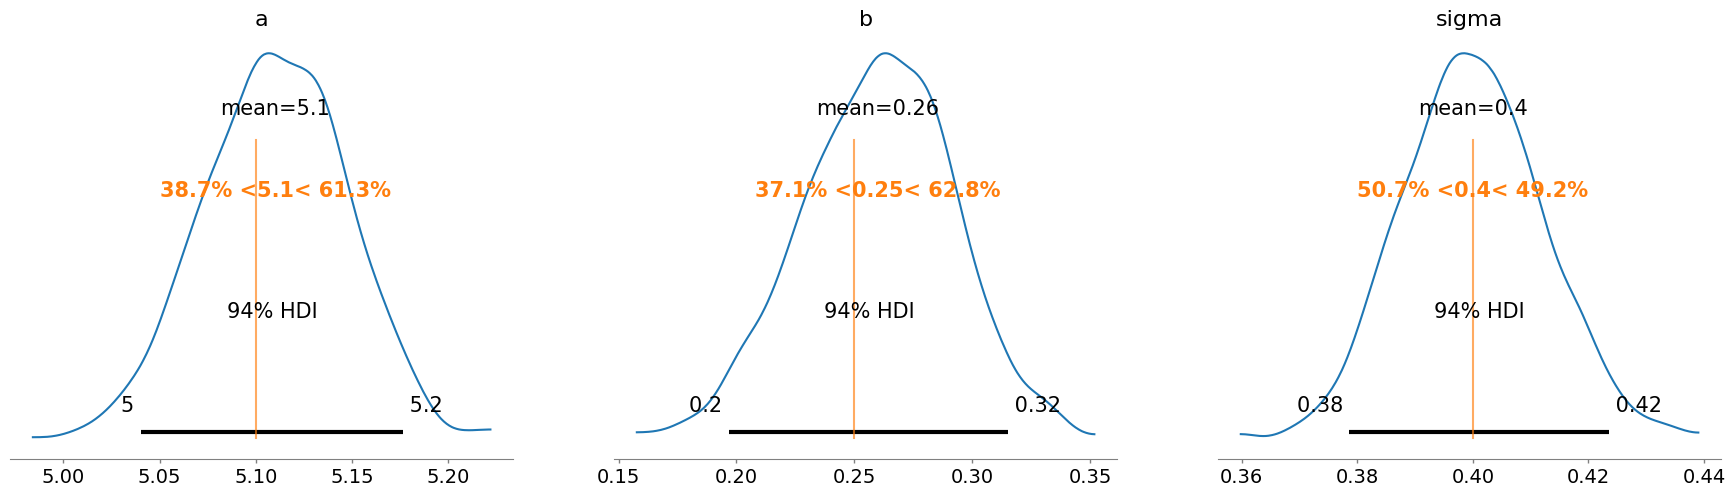

In [10]:
az.plot_posterior(idata_test, var_names=["a", "b", "sigma"],
                  ref_val=[a_sim, b_sim, sigma_sim])

*(Provide a brief discussion of the simulation results, confirming that your model can successfully recover the fixed parameters.)*

The chosen priors successfully capture the true values of the simulated parameters alpha, beta, and sigma. Their true values fall within the 94% HDI of their respective posteriors, and each posterior distribution is roughly centered around the corresponding true value.

## 5. Data Preparation (Real Data)

*(Load the real dataset. Perform any necessary cleaning, scaling, or transformations. )*

In [ ]:
# Load data

# Perform any cleaning/scaling/transformations

In [11]:
# Access the database through Google Drive
# to avoid re-downloading the large file each time

from google.colab import drive
drive.mount('/content/drive')

import sqlite3

db_path = "/content/drive/MyDrive/cs_conf_release.db"
conn = sqlite3.connect(db_path)

Mounted at /content/drive


In [12]:
import re

# Helper function to extract the first author ID
def extract_first_author(text):
    if not isinstance(text, str):
        return None
    match = re.search(r'["\']([^"\']+)["\']', text)
    return match.group(1) if match else None


In [13]:
# Load submission IDs, corresponding author IDs, and submission years
submission_df = pd.read_sql_query("""
    SELECT
        id AS submission_id,
        authorids,
        CAST(conf_year AS INTEGER) AS submission_year
    FROM submissions
""", conn)

# Extract the first author ID, since only the first author's citation count will be used
submission_df["first_author_id"] = submission_df["authorids"].apply(extract_first_author)
submission_df = submission_df.dropna(subset=["first_author_id"])

# Add a column for the year before the submission year
submission_df["prev_year"] = submission_df["submission_year"] - 1

In [16]:
# Load submission IDs and their corresponding average ratings
rating_df = pd.read_sql_query("""
    SELECT
        forum AS submission_id,
        AVG(rating_int) AS avg_rating
    FROM reviews
    GROUP BY forum
""", conn)

# Load author IDs and their cumulative citation counts at a given year
citation_df = pd.read_sql_query("""
    SELECT
        author_id,
        CAST(year AS INTEGER) AS year,
        CAST(cite AS FLOAT) AS cite
    FROM author_gscholar_citation
""", conn)
# Drop rows with duplicated author ID and year
citation_df = citation_df.drop_duplicates(subset=["author_id", "year"])

# Load submission IDs and their corresponding primary keywords, to be used as topics of interest
keyword_df = pd.read_sql_query("""
    SELECT
        submission_id,
        primary_keyword
    FROM submission_main_keyword
""", conn)

In [20]:
# Merge all extracted dataframes
# df contains each submission's average rating, primary keyword,
# and the first author's citation count from the year prior to submission

df = (
    submission_df
    .merge(rating_df, on="submission_id", how="inner")
    .merge(keyword_df, on="submission_id", how="inner")
    .merge(citation_df,
           left_on=["first_author_id", "prev_year"],
           right_on=["author_id", "year"],
           how="inner")
)
df = df.drop(columns=["author_id", "year", "authorids"])

In [18]:
# Helper function to filter the df to only include the top-k most frequent primary keywords
# Returns the filtered df and the list of top-k keywords
def get_topk_keyword_df(df, k):
    top_keywords = (
        df["primary_keyword"]
        .value_counts()
        .head(k)
        .index
        .tolist()
    )
    # Filter df
    df_topk = df[df["primary_keyword"].isin(top_keywords)].reset_index(drop=True)

    return df_topk, top_keywords


In [21]:
TOP_KEYWORD = 10

# df_topk includes only submissions whose primary keyword is among the top 10 most frequent ones
df_topk, top_keywords = get_topk_keyword_df(df, TOP_KEYWORD)
df_topk

,submission_id,submission_year,first_author_id,prev_year,avg_rating,primary_keyword,cite
0,o29tNZZqGcN,2021,~Chen_Wang2,2020,5.000000,graph neural networks,119.0
1,uxpzitPEooJ,2021,~Chen_Cai1,2020,6.500000,graph neural networks,52.0
2,9z_dNsC4B5t,2021,~Yingjun_Du1,2020,5.750000,meta-learning,22.0
3,aDjoksTpXOP,2021,~Alberto_Bietti1,2020,7.000000,deep learning,112.0
4,Wi5KUNlqWty,2021,~Dongkwan_Kim1,2020,6.000000,graph neural networks,5.0
...,...,...,...,...,...,...,...
1138,2s4sNT11IcH,2022,~Zhiqi_Bu1,2021,4.750000,deep learning,95.0
1139,kUGYDTJUcuc,2022,~GANG_CHEN1,2021,4.000000,reinforcement learning,8295.0
1140,XJFGyJEBLuz,2022,~Zhen_Qin5,2021,4.666667,neural networks,115.0
1141,mKsMcL8FfsV,2022,~Bram_Wallace1,2021,4.500000,self-supervised learning,25.0


In [22]:
def standardize(series):
    return (series - series.mean()) / series.std()

In [23]:
# Apply log(1 + x) transformation to the citation count
# And then standardize to obtain C
C = standardize(np.log1p(df_topk["cite"]))

R = df_topk["avg_rating"]

In [34]:
T = pd.Categorical(df_topk["primary_keyword"]).codes
n_topic = len(np.unique(T))

## 6. Posterior Model (Analysis on Real Data)

*(This section contains the code for your computational model and the analysis of its output.)*

### 6.1. Computational Model Definition and Sampling

*(Provide the code for your PyMC model.  Ensure the code is well-organized and understandable. )*

In [ ]:
# Define your statistical model in code (e.g., with pm.Model() as model: ...) and sample from the model


### 6.2. Model Diagnostics

*(Use built-in diagnostics to assess the quality of the posterior samples (e.g., trace plots, r-hat, effective sample size). )*

In [ ]:
# Show posterior summary

# Plot trace plots

# Check R-hat and ESS

*(Briefly discuss the diagnostics. Did the model converge? Are the samples of good quality?)*

## 7. Posterior Predictive Checks

*(Visually compare your model's posterior predictions to the observed data. )*

*(The plot(s) in this section should include: )*
* *The observed data*
* *The posterior mean*
* *The uncertainty of the posterior mean (e.g., 89% HDI)*
* *The uncertainty of posterior predictions (e.g., 89% HDI)*

In [ ]:
# Generate posterior predictive samples

# Create the posterior predictive check plot(s)


*(Discuss the results of the check(s). How well does your posterior approximation fit the observed data? Are there any notable discrepancies? )*

## 8. Discussion and Conclusion

### 8.1. Answering the Question

*(Discuss what was learned from the model. )*
* *What is the answer to the question you posed in the introduction?*
* *What is your estimate for the causal effect? Provide a plot showing the estimate of the distribution of the causal effect.*
* *Ensure your conclusions are supported by the evidence from your model results. *

### 8.2. Addressing the Confound

*(Explicitly address the confounding variable in your discussion. )*
* *What was the effect of the confound?*

## 9. Future Work

*(Use your current model results to guide future plans for expanding the analysis. )*

* *What are the limitations of your model?*
* *What other variables would you want to include to expand your inquiry?*
* *What other questions might you explore given what you have learned from your analysis?*

## 10. Group Member Contributions

*(List each section of the proposal and final write-up and state who worked on it.)*

**Example:**
* **Proposal:** Member Name 1, Member Name 2, Member Name 3
* **Introduction:** Member Name 1
* **Causal Model:** Member Name 2
* **Statistical Model:** Member Name 3
* **Model Validation on Simulated Data:** Member Name 1, Member Name 2
* **Data Preparation:** Member Name 3
* **Posterior Model (Analysis on Real Data):** Member Name 1
* **Posterior Predictive Checks:** Member Name 2
* **Discussion and Conclusion:** Member Name 3
* **Future Work:** Member Name 1, Member Name 2, Member Name 3
